## Anomaly Detection: catching credit card fraud with Python

[Card fraud impacts a fraction of one percent of all purchases made with plastic] [src]. Thus even a dumb model that classifies every transaction as "Not fraudulent" would give 99% accuracy at worst. This however does not address the business needs of detecting these 1% transactions.

The article linked in the first line in this post goes on to explain that in 2015 global Credit card and debit card fraud resulted in losses amounting to $21.84 billion. Card issuers ate 72% of this and merchants 28% of those losses.

Kaggle has posted a [great data set] [data_set] that illustrates this point quiet succinctly:

>This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It also further goes on to point out that since we have such skewed data calculating model accuracy by itself from the confusion matrix would not carry much meaning.

[src]: https://wallethub.com/edu/credit-debit-card-fraud-statistics/25725/
[data_set]:https://www.kaggle.com/dalpozz/creditcardfraud


## The Dataset

This dataset has 284,807 rows of credit card transaction data from European cardholders in the month of September 2013 over a period of 2 days. The 28 features of this data set are the principal components obtained after performing a [PCA] [pca_info] on the original data followed by anonymisation to protect [PII] [pii_info], from the description of the data set:

>the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

[pca_info]: https://en.wikipedia.org/wiki/Principal_component_analysis
[pii_info]:https://en.wikipedia.org/wiki/Personally_identifiable_information

## Measuring Success

In a Binary Classification Problem it’s often advantageous to use a confusion matrix like the one below in the form of a 2x2 matrix.

|                   | Predicted Yes Fraud   | Predicted No Fraud  |
|-------------------|-----------------------|---------------------|
| Actual Yes Fraud  | true positives        | false negative      |
| Actual No Fraud   | false positives       | true negative       |

The basic definitions of this are:

*  true positives (TP): These are cases in which we predicted yes there is fraud, and in actuality fraud was committed.
* true negatives (TN): We predicted no fraud, and in actuality no fraud was committed
* false positives (FP): We predicted yes fraud occurred, but there was no fraud perpetrated. (Also known as a "Type I error.")
* false negatives (FN): We predicted no fraud, but there actually was fraud committed. (Also known as a "Type II error.")

Using this information a lot of useful parameters can be calculated like:

1. Accuracy: Overall, how often is the classifier correct?
 * = (TP+TN)/total
2. Misclassification Rate: Overall, how often is it wrong?
 * = (FP+FN)/total
3. True Positive Rate or "Recall" or "Sensitivity" : When it's actually fraud, how often does it predict fraud?
 * = TP/actual fraud = TP/(FN + TP).
4. False Positive Rate: When it's actually no fraud , how often does it predict fraud?
 * = FP/actual no 
5. Specificity: When it's actually no fraud, how often does it predict no fraud?
 * = TN/actual no fraud
 * equivalent to 1 minus False Positive Rate

In this case we are most concerned with Recall (without sacrificing too much accuracy) since if it is a fraud we want to catch it!

## Initialise

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

#### Load the Data

In [28]:
data= pd.read_csv("creditcard.csv")

#### Check if it really is as badly distributed as claimed

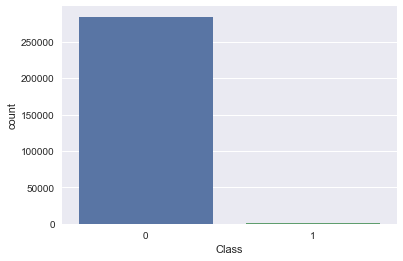

In [33]:
sns.countplot("Class",data=data)

Thus its clear from the graph that most of the data is not fraudulent (recall that class = 0 is not fraud, and class=1 is fraud)

#### Split the data into train and test

In [3]:
X = data.ix[:,1:29]
Y = data.Class
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.3)

## Logistic regression

Its so common to run a Logistic Regression for a binary target variable with multiple features that I would go as far as to call it a cliché

In [4]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)

#### Checking the accuracy of Logistic Regression:

In [5]:
cnf_matrix = confusion_matrix(Y_test, Y_pred,labels=[1,0])
print (cnf_matrix)
print("Accuracy "+str((cnf_matrix[0,0]+cnf_matrix[1,1])/(cnf_matrix[0,0] + cnf_matrix[0,1]+cnf_matrix[1,0] + cnf_matrix[1,1])*100) + " %")
print ('Recall: ' + str(np.round(100*float((cnf_matrix[0][0]))/float((cnf_matrix[0][0]+cnf_matrix[0][1])),2))+'%')

[[   89    61]
 [   10 85283]]
Accuracy 99.9169036668 %
Recall: 59.33%


#### Logistic Regression Conclusion
Here accuracy is high, but as we discussed earlier that means very little in such a skewed data set, however we do see that recall is quiet poor, we let 40% of the fraudulent transactions through 

## Random Forest

Random Forest is another one of those out of the box "basic" algorithms everyone uses, it also happens to be one of my favourites.

In [6]:
rf = RandomForestClassifier(n_jobs =-1)
rf.fit(X_train, Y_train)
Y_rf_pred = rf.predict(X_test)

#### Checking the accuracy of Random Forest

In [7]:
cnf_matrix = confusion_matrix( Y_test,Y_rf_pred,labels=[1,0])
print (cnf_matrix)
print("Accuracy "+str((cnf_matrix[0,0]+cnf_matrix[1,1])/(cnf_matrix[0,0] + cnf_matrix[0,1]+cnf_matrix[1,0] + cnf_matrix[1,1])*100) + " %")
print ('Recall: ' + str(np.round(100*float((cnf_matrix[0][0]))/float((cnf_matrix[0][0]+cnf_matrix[0][1])),2))+'%')

[[  113    37]
 [    8 85285]]
Accuracy 99.9473333099 %
Recall: 75.33%


#### Random Forest Conclusion
Here we clearly see that accuracy is much improved but we still let through about 25% of the fraudulent transactions

## SVM

SVM is fairly popular supervised binary classification algorithm.

In [8]:
classifier= SVC(random_state= 0)
classifier.fit(X_train, Y_train.ravel())
Y_SVM_pred = classifier.predict(X_test)

#### Checking the accuracy of SVM

In [9]:
cnf_matrix = confusion_matrix( Y_test,Y_SVM_pred,labels=[1,0])
print (cnf_matrix)
print("Accuracy "+str((cnf_matrix[0,0]+cnf_matrix[1,1])/(cnf_matrix[0,0] + cnf_matrix[0,1]+cnf_matrix[1,0] + cnf_matrix[1,1])*100) + " %")
print ('Recall: ' + str(np.round(100*float((cnf_matrix[0][0]))/float((cnf_matrix[0][0]+cnf_matrix[0][1])),2))+'%')

[[  102    48]
 [    4 85289]]
Accuracy 99.9391407137 %
Recall: 68.0%


#### SVM Conclusion
Here we clearly see that accuracy is worse than Random Forest and we let through about 32% of the fraudulent transactions

## Naive Bayes

This algorithm is known to be extremely fast relative to other classification algorithms. It works on Bayes theorem of probability to predict the class of unknown data set.

In [15]:
NBmodel = GaussianNB()
NBmodel.fit(X_train, Y_train)
Y_NB_pred= NBmodel.predict(X_test)

In [16]:
cnf_matrix = confusion_matrix( Y_test,Y_NB_pred,labels=[1,0])
print (cnf_matrix)
print("Accuracy "+str((cnf_matrix[0,0]+cnf_matrix[1,1])/(cnf_matrix[0,0] + cnf_matrix[0,1]+cnf_matrix[1,0] + cnf_matrix[1,1])*100) + " %")
print ('Recall: ' + str(np.round(100*float((cnf_matrix[0][0]))/float((cnf_matrix[0][0]+cnf_matrix[0][1])),2))+'%')

[[  124    26]
 [ 1779 83514]]
Accuracy 97.8874805426 %
Recall: 82.67%


#### Naive Bayes Conclusion
Here we clearly see that accuracy is the highest we have got so far but accuracy has fallen a bit, this has happened because we have got a few more False positives, i.e. we tagged some legitimate transacations as fraudulent transactions

## Undersampling

At this point it is clear that the severly imbalanced data set is causing a few problems to our ML algorithms, a few reasons why this happens is:

1. Unequal distribution of the dependent variable causes the performance of existing classifiers to get biased towards the majority class
2. ML algorithms (in General) are accuracy driven i.e. they aim to minimize the overall error to which the minority class contributes very little

Thus to remedy this situation and improve our models with an unbalanced dataset like this we need to use undersampling. This means training the model on a training set where the “normal” data is undersampled so it has the same size as the fraudulent data.

Note that there are otherways to handle imbalanced data but for the purposes of this post Undersampling is what we are going with.[For other options on correcting imbalanced data sets click here] [imba]

[imba]: https://www.analyticsvidhya.com/blog/2016/03/practical-guide-deal-imbalanced-classification-problems/

#### Generating undersampled train and test data

In [22]:
fraud_data = len(data[data.Class == 1])
fraud_indices = data[data.Class == 1].index
normal_indices = data[data.Class == 0].index
undersample_indices = np.random.choice(normal_indices, fraud_data, False)
data_undersampled = data.iloc[np.concatenate([fraud_indices,undersample_indices]),:]
X_undersampled = data_undersampled.ix[:,1:29]
Y_undersampled = data_undersampled.Class
X_undersampled_train, X_undersampled_test, Y_undersampled_train, Y_undersampled_test = train_test_split(X_undersampled,Y_undersampled,test_size = 0.3)

## Logistic Regression on Undersampled training Data

In [25]:
lr_us = LogisticRegression()
lr_us.fit(X_undersampled_train, Y_undersampled_train)
Y_full_lr_pred = lr_us.predict(X_test)

#### Checking the accuracy of Logistic Regression with undersampling:

In [26]:
cnf_matrix = confusion_matrix(Y_test, Y_full_lr_pred,labels=[1,0])
print (cnf_matrix)
print("Accuracy "+str((cnf_matrix[0,0]+cnf_matrix[1,1])/(cnf_matrix[0,0] + cnf_matrix[0,1]+cnf_matrix[1,0] + cnf_matrix[1,1])*100) + " %")
print ('Recall: ' + str(np.round(100*float((cnf_matrix[0][0]))/float((cnf_matrix[0][0]+cnf_matrix[0][1])),2))+'%')

[[  138    12]
 [ 2718 82575]]
Accuracy 96.8048874688 %
Recall: 92.0%


#### Logistic Regression with undersampled Conclusion
Thus we see by just undersampling the training data we have improved our recall tremendously

## SVM on undersampled data

In [34]:
classifier_us= SVC(random_state= 0)
classifier_us.fit(X_undersampled_train, Y_undersampled_train.ravel())
Y_SVM_us_pred = classifier_us.predict(X_test)

#### Checking the accuracy of SVM

In [35]:
cnf_matrix = confusion_matrix( Y_test,Y_SVM_us_pred,labels=[1,0])
print (cnf_matrix)
print("Accuracy "+str((cnf_matrix[0,0]+cnf_matrix[1,1])/(cnf_matrix[0,0] + cnf_matrix[0,1]+cnf_matrix[1,0] + cnf_matrix[1,1])*100) + " %")
print ('Recall: ' + str(np.round(100*float((cnf_matrix[0][0]))/float((cnf_matrix[0][0]+cnf_matrix[0][1])),2))+'%')

[[  141     9]
 [ 3995 81298]]
Accuracy 95.3138349543 %
Recall: 94.0%


#### SVM under sampled data Conclusion
Once again we see that we have a minor drop in accuracy but a huge increase in Recall

## Naive Bayes on Under Sampled Data

In [36]:
NBmodel_us = GaussianNB()
NBmodel_us.fit(X_undersampled_train, Y_undersampled_train)
Y_NB_us_pred= NBmodel_us.predict(X_test)

In [38]:
cnf_matrix = confusion_matrix( Y_test,Y_NB_us_pred,labels=[1,0])
print (cnf_matrix)
print("Accuracy "+str((cnf_matrix[0,0]+cnf_matrix[1,1])/(cnf_matrix[0,0] + cnf_matrix[0,1]+cnf_matrix[1,0] + cnf_matrix[1,1])*100) + " %")
print ('Recall: ' + str(np.round(100*float((cnf_matrix[0][0]))/float((cnf_matrix[0][0]+cnf_matrix[0][1])),2))+'%')

[[  126    24]
 [ 2797 82496]]
Accuracy 96.6983837178 %
Recall: 84.0%


#### Naive Bayes undersampled data Conclusion
Here undersampling does not seem to have improved the recall much for naive bayes

# Conclusion

Here we conclude that the algorithms in descending order of recall were:

1. SVM on under sampled training data : 
 * Recall: 94.0%
 * Accuracy 95.31%
2. Logistic Regression on under sampled data:
 * Recall: 92.0%
 * Accuracy 96.80%
3. Naive Bayes on under sampled data:
 * Recall: 84.0%
 * Accuracy 96.69%